Using device: cuda
Epoch [1/5], Loss: 1.6539
Accuracy of the model on the test images: 83.64%
Model saved at ./checkpoints/model_epoch_1.pth
Epoch [2/5], Loss: 0.0462
Accuracy of the model on the test images: 83.52%
Model saved at ./checkpoints/model_epoch_2.pth
Epoch [3/5], Loss: 0.0169
Accuracy of the model on the test images: 89.84%
Model saved at ./checkpoints/model_epoch_3.pth
Epoch [4/5], Loss: 0.0084
Accuracy of the model on the test images: 90.83%
Model saved at ./checkpoints/model_epoch_4.pth
Epoch [5/5], Loss: 0.0018
Accuracy of the model on the test images: 89.71%
Model saved at ./checkpoints/model_epoch_5.pth


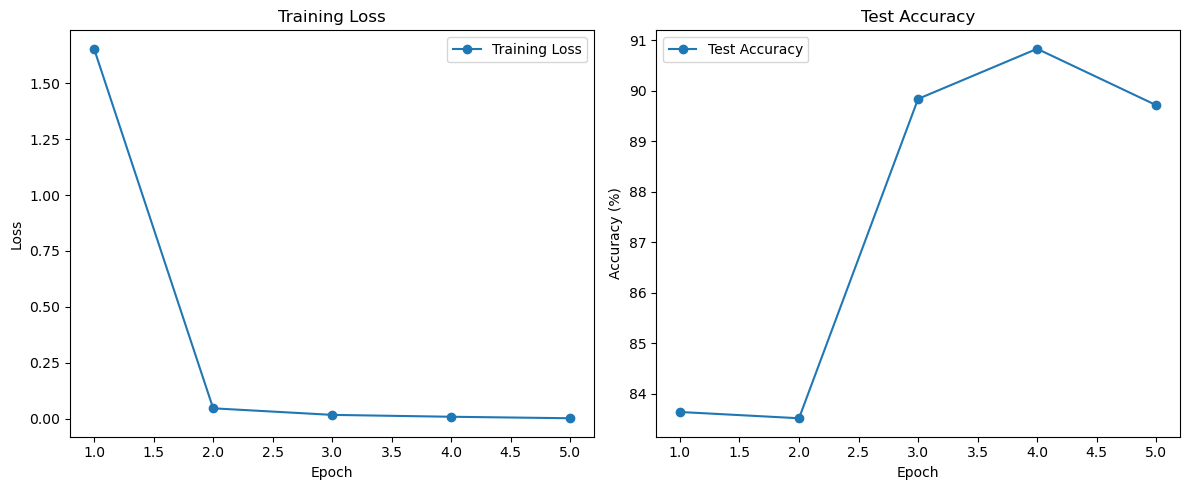

Accuracy of the model on the test images: 89.71%


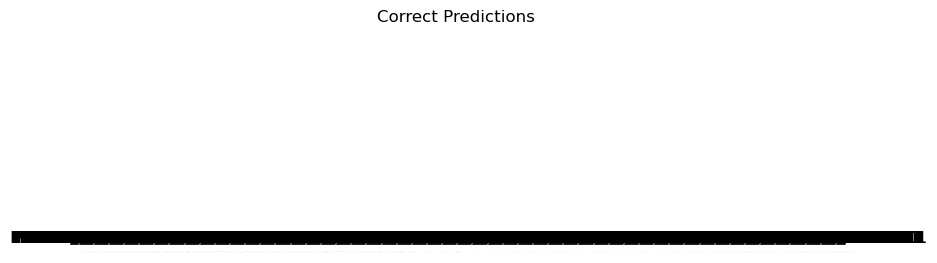

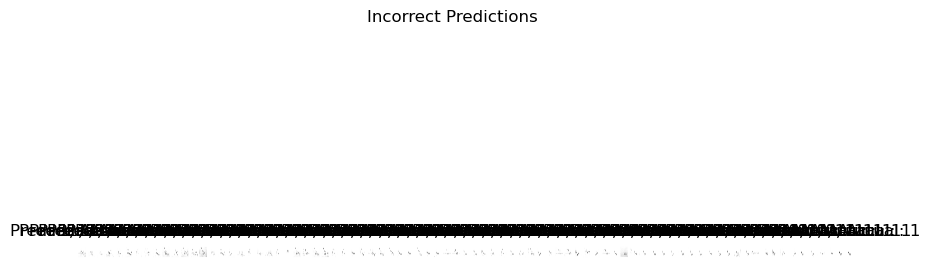

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available, set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')  # Prints 'cuda' if GPU is available, else 'cpu'

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 5
image_size = (960, 480)  # Image size

# Define the transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 960x480 pixels
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image between -1 and 1
])

# Load the datasets
train_dataset = datasets.ImageFolder(root='/home/zubair/Downloads/CNN Data/Training Dataset', transform=transform)
test_dataset = datasets.ImageFolder(root='/home/zubair/Downloads/CNN Data/Test Dataset', transform=transform)

# DataLoader (to handle batch processing)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Define the CNN model for larger input size
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, device=device)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Calculate the size of the flattened output after conv + pooling
        conv_output_size = self._get_conv_output_size(image_size)

        self.fc1 = nn.Linear(conv_output_size, 128)  # Adjusted fully connected layer
        self.fc2 = nn.Linear(128, len(train_dataset.classes))  # Output layer for the number of classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Output layer
        return x

    def _get_conv_output_size(self, img_size):
        """Helper function to calculate the size of the tensor after conv + pool."""
        with torch.no_grad():
            dummy_input = torch.ones(1, 3, *img_size).to(device)  # Move dummy input to the GPU/CPU
            x = self.pool(torch.relu(self.conv1(dummy_input)))  # Conv1 + Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + Pool
            return x.numel()
        
    def predict(self, input_tensor):
        """Predict class for the input tensor."""
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            output = self.forward(input_tensor)  # Forward pass
            probabilities = nn.Softmax(dim=1)(output)  # Convert logits to probabilities
            predicted_classes = torch.argmax(probabilities, dim=1)  # Get the index of the class with max probability
            return predicted_classes.cpu().numpy(), probabilities.cpu().numpy()  # Return as NumPy arrays


# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)  # Move the model to the GPU/CPU
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Plot correct and incorrect predictions
def plot_images(images, labels, predictions, title):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        imshow(images[i])
        plt.title(f'Pred: {predictions[i]}, Actual: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Helper function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()  # Ensure the tensor is on the CPU before displaying
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Testing function that plots correct and incorrect predictions
def test_model_with_plots(model, test_loader, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] == labels[i] :
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].item())
                    correct_preds.append(predicted[i].item())
                elif predicted[i] != labels[i] :
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].item())
                    incorrect_preds.append(predicted[i].item())

    print(f'Accuracy of the model on the test images: {100 * len(correct_images) / len(test_loader.dataset):.2f}%')

    # Plot correct predictions
    plot_images(correct_images, correct_labels, correct_preds, 'Correct Predictions')

    # Plot incorrect predictions
    plot_images(incorrect_images, incorrect_labels, incorrect_preds, 'Incorrect Predictions')

import os

# Directory to save model checkpoints
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
test_accuracy_list = []


# Modify the training function to save loss, accuracy, and model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, save_dir):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            running_loss += loss.item()

        # Average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_loss_list.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Test accuracy at the end of each epoch
        test_accuracy = test_model(model, test_loader, device)
        test_accuracy_list.append(test_accuracy)

        # Save model after each epoch
        checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'accuracy': test_accuracy
        }, checkpoint_path)

        print(f'Model saved at {checkpoint_path}')

    return train_loss_list, test_accuracy_list


# Modify the test function to return accuracy
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU/CPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy


# Function to plot the loss and accuracy
def plot_metrics(train_loss_list, test_accuracy_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, '-o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracy_list, '-o', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Train the model and save metrics
train_loss_list, test_accuracy_list = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs,
                                                  device, save_dir)

# Plot loss and accuracy
plot_metrics(train_loss_list, test_accuracy_list)

# Test the model and plot correct and incorrect predictions
test_model_with_plots(model, test_loader, device=device)


In [6]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm
import lime.lime_image
model.eval()

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer()


# Function to preprocess input image for the model
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    return transform(image).unsqueeze(0)

# Initialize a dictionary to store one image for each digit
digit_examples = {} # 'Bewickii images', 'Mexicanus images'

# Iterate over the test data loader to collect one example for each digit
for images, labels in test_loader:
    labels_list = labels.tolist()
    for i, label in enumerate(labels_list):
        if label not in digit_examples:
            # Detach the image tensor and convert to numpy array
            digit_examples[label] = images[i].detach().numpy()

        # If we've collected all digits, break out of loop
        if len(digit_examples) == 10:
            break

    # If we've collected all digits, break out of loop
    if len(digit_examples) == 10:
        break

# Create a SegmentationAlgorithm object with 'slic' algorithm
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

    
# Now iterate through each digit and explain using LIME
for digit in range(10):
    # Retrieve the selected image of the digit from the dictionary
    image = np.squeeze(digit_examples[digit])

    # Get explanation from LIME
    explanation = explainer.explain_instance(image,
                                             model.predict)

    # Get image and mask for the explanation of the digit
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Plot the image and the explanation
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image: {digit}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for {digit}')
    plt.axis('off')

    plt.show()


ValueError: Only RGB images can be converted to Lab space.